In [184]:
import numpy as np
from itertools import product
import pandas as pd
import random
from collections import defaultdict
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
class TicTacToe():
    def __init__(self, player = 'X', reward_type='goal_reward'): # set X to start game
        self.board = np.array(['__']*9).reshape(3,3)
        self.reward_type = reward_type
        self.winning_seqeunce = None #Keep track of winning move made by agent
        self.first_move = None #Keep track of first move made by agent
        if player == 'X':
            self.me ='X'
            self.id = 1
            self.opponent = 'O'
        else:
            self.me = 'O'
            self.id = 2
            self.opponent = 'X'

        self.game_over = False #Flag indicating whether game is over
        self.b_to_s = {'__':0, 'X':1, 'O':2} 
        self.s_to_b = {0:'__', 1:'X', 2:'O'} 
        
        positions = self.available_positions()
        self.b2_to_s1 = {position:i for (i, position) in enumerate(positions)} # map from 2D position in board to 1D position in tuple
        self.s1_to_b2 = {i:position for (i, position) in enumerate(positions)}
        self.starting_state = self.board_to_state() #State the current player is in
        l_o_l = [list(range(3)) for _ in range(9)] #Initialize all possible states of the game
        states = set(product(*l_o_l))

        playerX_states = {state for state in states if (state.count(0)%2 == 1 and state.count(1)==state.count(2))} #
        playerO_states =  {state for state in states if (state.count(0)%2 == 0 and state.count(1)==(state.count(2)+1))}
        
        #States 
        #self.board_full_states = {state for state in states if state.count(0)==0}
        if player == 'X':
            self.my_states = playerX_states
        else:
            self.my_states = playerO_states
    
    def reset_board(self):
        self.board = np.array(['__']*9).reshape(3,3)
        self.starting_state = self.board_to_state()
        self.game_over = False
        self.winning_sequence = None
        self.first_move = None
    
    def show_board(self):
        return pd.DataFrame(self.board)
    
    def board_to_state(self):
        return tuple([self.b_to_s[x] for x in np.ravel(self.board)])
   
    @staticmethod
    def possible_actions(state):
        return [i for i,x in enumerate(state) if x ==0]

    def is_game_over(self):
        if not np.any(self.board == '__') :
            self.game_over = True
        return self.game_over

    def available_positions(self):
        x,y = np.where(self.board =='__')
        return[(x,y) for x,y in zip(x,y)]
    
    def win(self, player):
        if np.all(self.board[0,:] == player):
            self.winning_sequence = 'R1'
        elif np.all(self.board[1,:] == player): 
            self.winning_sequence = 'R2'
        elif np.all(self.board[2,:] == player):
            self.winning_sequence = 'R3'
        elif np.all(self.board[:,0] == player):
            self.winning_sequence = 'C1'
        elif np.all(self.board[:,1] == player):
            self.winning_sequence = 'C2'
        elif np.all(self.board[:,2] == player):
            self.winning_sequence = 'C3'
        elif np.all(self.board.diagonal()==player):
            self.winning_sequence = 'D1'
        elif  np.all(np.fliplr(self.board).diagonal()==player):
            self.winning_sequence = 'D2'
        else:
            return False   
        return True

    def my_move(self, position): # 1 is me and 0 is the opponent
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.me
        
        I_win = self.win(self.me)
        opponent_win = self.win(self.opponent)
        
        if self.reward_type == 'goal_reward':
            if I_win:
                self.game_over = True
                return 1
            elif opponent_win:
                self.game_over = True
                return -1
            else:
                return 0
            
        elif self.reward_type == 'action_penalty':
            if I_win:
                self.game_over = True
                return 0
            elif opponent_win:
                self.game_over = True
                return -10
            else:
                return -1
    
    def opponent_move(self, position):
        "Fills out the board in the given position with the action of the opponent"
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.opponent
    
    def get_action(self, next_state):
        " return action that will take agent to the specified next state"
        current_state = self.board_to_state()
        return [i for (i,j) in enumerate(current_state) if current_state[i]==0 and next_state[i]==self.id][0]
        
    def pick_best_action(self, Q, action_type, eps=None):
        #Get possible actions
        current_state = self.board_to_state()
        actions =  self.possible_actions(current_state)
        
        best_action = []
        best_action_value = -np.Inf
        
        for action in actions:
            Q_s_a = Q[current_state][action]
            if Q_s_a == best_action_value:
                best_action.append(action)
            elif Q_s_a > best_action_value:
                best_action = [action]
                best_action_value = Q_s_a
        best_action = random.choice(best_action)

        if action_type == 'greedy':
            return self.s1_to_b2[best_action]
        else:
            assert eps != None , "Include epsilon parameter"
            n_actions = len(actions) #No of legal actions 
            p = np.full(n_actions, eps/n_actions) 
            best_action_i = actions.index(best_action) #Get index of best action
            p[best_action_i] += 1 - eps
            return self.s1_to_b2[np.random.choice(actions, p=p)]

In [186]:

def play_games(n_games, Q_X, Q_O, X_strategy='eps_greedy', O_strategy='eps_greedy', eps_X=0.05, eps_O=0.05, seed=1):
    """ 
        Function to play tic tac toe specified no of times, and return summary of win statistics
        n_games: No of times to play the game
        Q_X: Q function for player X that gives X's policy
        Q_O: Q function for player O that gives O's policy
        X_strategy: eps_greedy or greedy
        O_strategy: eps_greedy or greedy j
    """
    np.random.seed(seed)
    win_stats = defaultdict(int) # Dictionary for holding results of simulation
    final_boards = [] #List of final boards
    t_board_X = TicTacToe(player = 'X', reward_type = 'action_penalty')
    t_board_O = TicTacToe(player = 'O', reward_type = 'action_penalty')
    winning_sequences_X = [] # List to hold winning sequences of the winning player if X wins
    winning_sequences_O = [] # List to hold winning sequences of the winning player if O wins
    X_first_actions = [] #List to record first actions of player X
    O_first_actions = [] #List to record first actions of player O
    winning_X_first_actions = [] #List to record first actions that resulted in wins
    winning_O_first_actions = [] #List to record first actions that resulted in wins
    
    for i in tqdm(range(n_games), position=0 ,leave=True): # play n_games times of game
        first_action_flag = True
        while True:
            #X plays first
            x_action = t_board_X.pick_best_action(Q_X, action_type=X_strategy, eps=eps_X)
            if first_action_flag == True:
                X_first_actions.append(x_action)
            t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board
            if t_board_X.is_game_over(): #need to end game here if X makes the winning move
                break
            #O plays second
            o_action = t_board_O.pick_best_action(Q_O, action_type=O_strategy, eps=eps_O)
            if first_action_flag == True:
                O_first_actions.append(o_action)
                first_action_flag = False
            t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board
            if t_board_O.is_game_over(): #need to end game here if O makes the winnng move
                break
        
        #Check who won game or if game was drawn
        if t_board_X.win('X'):
            win_stats['X_win'] += 1
            winning_sequences_X.append(t_board_X.winning_sequence)
            winning_X_first_actions.append(X_first_actions[-1])
            
        elif t_board_X.win('O'):
            win_stats['O_win'] += 1
            winning_sequences_O.append(t_board_O.winning_sequence)
            winning_O_first_actions.append(O_first_actions[-1])
        else:
            win_stats['Draw'] += 1
        final_boards.append(t_board_X.show_board())
        t_board_X.reset_board()
        t_board_O.reset_board()
    
    return win_stats, final_boards, winning_sequences_X, winning_sequences_O, \
           X_first_actions, O_first_actions, winning_X_first_actions, winning_O_first_actions

def get_win_statistics(Q_X, Q_O, sets = 5, games_in_set = 100, X_strategy = 'eps_greedy', O_strategy='eps_greedy', eps_X=1.0, eps_O=1.0):
    """
        Function to get winning statistics by pitting competing strategies. 
        Q_X: Q table representing the strategy of X
        Q_O: Q Table representing the strategy of O
        sets: No of sets to be played
        games_in_set: No of games in each set
        X_strategy: greedy or epsilon greedy
        O_strategy: greedy or epsilon greedy
        eps_X and eps_O: epsilon in case of epsilon greedy strategy, set to 1 for random strategy
    """
    win_stats_list = []
    winning_sequences_X_list = []
    winning_sequences_O_list = []
    X_first_actions_list = []
    O_first_actions_list = []
    winning_X_first_actions_list = []
    winning_O_first_actions_list = []

    for i in range(sets):
        win_stats, _, winning_sequences_X, winning_sequences_O, X_first_actions, O_first_actions, winning_X_first_actions, winning_O_first_actions \
            = play_games(n_games=games_in_set, Q_X=Q_X, Q_O=Q_O, X_strategy=X_strategy, O_strategy=O_strategy, eps_X=eps_X, eps_O=eps_O, seed=i)
        win_stats_list.append(win_stats)
        winning_sequences_X_list.append(winning_sequences_X)
        winning_sequences_O_list.append(winning_sequences_O)
        X_first_actions_list.append(X_first_actions)
        O_first_actions_list.append(O_first_actions)
        winning_X_first_actions_list.append(winning_X_first_actions)
        winning_O_first_actions_list.append(winning_O_first_actions)
        
    #Unwrap these lists
    flatten =  lambda l:[item for sublist in l for item in sublist] 
    winning_sequences_X_list = flatten(winning_sequences_X_list)
    winning_sequences_O_list = flatten(winning_sequences_O_list)
    X_first_actions_list = flatten(X_first_actions_list)
    O_first_actions_list = flatten(O_first_actions_list)
    winning_X_first_actions_list = flatten(winning_X_first_actions_list)
    winning_O_first_actions_list = flatten(winning_O_first_actions_list)
    win_stats_df = pd.DataFrame(win_stats_list)

    return (win_stats_df), (winning_sequences_X_list, winning_sequences_O_list), (X_first_actions_list, winning_X_first_actions_list), (O_first_actions_list, winning_O_first_actions_list)           

#Mapping from 2D position to 1D position
map_2d_1d = {(0, 0): 0, (0, 1): 1,(0, 2): 2, (1, 0): 3, (1, 1): 4,(1, 2): 5,(2, 0): 6,(2, 1): 7,(2, 2): 8}

def get_win_rate(first_actions_list, winning_first_actions_list):
    "Get win rate in appropriate format from experiment results"
    first_actions = dict(Counter(first_actions_list))
    winning_first_actions = dict(Counter(winning_first_actions_list))
    win_rate = np.array([winning_first_actions.get(key,0)/first_actions.get(key,1) for key in sorted(map_2d_1d.keys())]).reshape(3,3)
    return win_rate

def get_win_seqs(winning_sequences_list):
    "Get winning sequence stats in appropriate format from experiment results"
    temp_dict = dict(Counter(winning_sequences_list))
    win_seq_df = pd.DataFrame({'winning_sequence':list(temp_dict.keys()),'N':list(temp_dict.values())})
    
    return win_seq_df

def plot_results(win_statistics):
    "Function to visualize results of experiments"
    sns.set(font_scale=5)
    final_results,winning_sequences,first_actions_X,first_actions_O = win_statistics
    win_stats_df_long = pd.melt(final_results,var_name='Result',value_name='N')
    plt.subplots_adjust(hspace = 2)
    fig, axs = plt.subplots(nrows = 2, ncols=2,figsize=(100,40))
    bplot = sns.boxplot(x="Result",y="N",data=win_stats_df_long, color='red', \
                ax=axs[0,0]).set_title("Distribution of Wins,Losses and Ties")

    #Plot aggregate results
    final_results_agg = pd.DataFrame(final_results.apply(sum,0),columns=["N"])
    final_results_agg.reset_index(level=0,inplace=True)
    splot = sns.barplot(x="index", y="N", data=final_results_agg, ax=axs[0,1], color='blue')
    for p in splot.patches: 
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -12), 
                       textcoords = 'offset points')
    splot.set_title('Total No of Wins,Losses and Ties')

    win_rate_X = get_win_rate(*first_actions_X)
    win_rate_O = get_win_rate(*first_actions_O)
    _ = sns.heatmap(win_rate_X, annot=True, cmap='seismic', ax=axs[1,1]).set_title("Player X: % of wins for first move")
    _ = sns.heatmap(win_rate_O, annot=True, cmap='seismic', ax=axs[1,0]).set_title("Player O: % of wins for first move") # RdBu_r

    plt.show()

def initialize_Q(S, seed = 1):
    "Given a state assign random values to each possible action"
    np.random.seed(seed)
    Q = {}
    for state in S:
        Q[state]= {}
        for i,x  in enumerate(state): # Loop through action
            if x == 0:
                Q[state][i] = np.random.rand()
    
    return Q

def moving_average(x, w):
    "Function to calculate moving average of rewards"
    return np.convolve(x, np.ones(w), 'valid') / w

def train(n_games=1000, alpha = 0.5, gamma = 0.9, train_X=True, train_O=False, is_random=True, **kwargs):
    """
        Function to train a player in a game of tic-tac-toe
        Arguments:
            n_games: Number of games on which to train
            alpha: Learning rate
            gamme: discount factor
            train_X: Flag indicating whether player X should be trained
            train_O: Flag inficating whether player O should be trained
            is_random: should actions of untrained agent be random or deterministic according to Q table
    """

    # If Q is not provided, randomize intially, if provided, it will be used to select actions greedily
    if "Q_X" in kwargs:
        action_type_X = "greedy"
        assert train_X == False ,"Train flag should be set to False if Q table is being provided"
        Q_X = kwargs["Q_X"]
    else:
        Q_X = initialize_Q(States_X)
        
    if "Q_O" in kwargs:
        action_type_O = "greedy"
        assert train_O == False ,"Train flag should be set to False if Q table is being provided"
        Q_O = kwargs["Q_O"]
    else:
        Q_O = initialize_Q(States_O)
    
    eps_ = lambda flag,i: 0.05*0.99**i if flag else 1.0 # Set epsilon value conditional on whether we are training X or O

    rewards_X = [] #Lists to keep track of rewards earned by both players during training
    rewards_O = []
    
    if train_X:
        X_action_type = 'eps_greedy'
    else:
        X_action_type = 'greedy'
        if is_random:
            X_action_type = 'eps_greedy'

    if train_O:
        O_action_type = 'eps_greedy'
    else:
        O_action_type = 'greedy'
        if is_random:
            O_action_type = 'eps_greedy'
            
    for i in tqdm(range(n_games), position=0, leave=True):
        
        eps = 0.05*0.99**i
        t_board_X.reset_board()
        t_board_O.reset_board()
        S_X = t_board_X.board_to_state() # X lands on empty board

        # X plays first
        eps = eps_(train_X, i) 
        x_action = t_board_X.pick_best_action(Q_X, action_type=X_action_type, eps=eps)
        x_action1d = t_board_X.b2_to_s1[x_action]
        R_X = t_board_X.my_move(x_action) # make move on X's board
        t_board_O.opponent_move(x_action) # make same move on O's board

        while not (t_board_X.is_game_over() or t_board_O.is_game_over()):
            S_O = t_board_O.board_to_state()

            # O plays second
            eps = eps_(train_O, i) 
            o_action = t_board_O.pick_best_action(Q_O, action_type=O_action_type, eps=eps)
            o_action1d = t_board_O.b2_to_s1[o_action]
            R_O = t_board_O.my_move(o_action) # make move on O's board
            t_board_X.opponent_move(o_action) # make same move on X's board
            if  t_board_O.is_game_over():   
                if train_O: # Need to end game here if O makes the winnng move and add a reward
                    Q_O[S_O][o_action1d] += alpha*(R_O + 0 - Q_O[S_O][o_action1d]) # 0 given value of terminal state is 0
                if train_X: # Need to penalize X's previous action if game is over
                    Q_X[S_X][x_action1d] += alpha*(-R_O + 0 - Q_X[S_X][x_action1d]) 
                rewards_O.append(R_O)
                rewards_X.append(- R_O)
                break
            S_X_new = t_board_X.board_to_state() # Get new state
            if train_X: # Calculate max_a Q_X(S',a)
                x_action_ = t_board_X.pick_best_action(Q_X,action_type = 'greedy',eps=0.05) #best action from S_new
                x_action_1d = t_board_X.b2_to_s1[x_action_]
                Q_X[S_X][x_action1d]+= alpha*(R_X + gamma*Q_X[S_X_new][x_action_1d] - Q_X[S_X][x_action1d])
            S_X = S_X_new
    
            # X plays next
            eps = eps_(train_X, i)
            x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
            x_action1d = t_board_X.b2_to_s1[x_action]
            R_X = t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board
            if t_board_X.is_game_over(): 
                if train_O:
                    #need to end game here if X makes the winning move and make sure O's action is penalized
                    Q_O[S_O][o_action1d] += alpha*(-R_X + 0 - Q_O[S_O][o_action1d]) #0 given value of terminal state is 0
                if train_X:
                    #need to end game here if X makes the winning move and make sure reward is added to V
                    Q_X[S_X][x_action1d] += alpha*(R_X + 0 - Q_X[S_X][x_action1d]) #0 given value of terminal state is 0
                rewards_X.append(R_X)
                rewards_O.append(-R_X)
                break   

            S_O_new = t_board_O.board_to_state() #Get new state
            if train_O: #Calculate max_a Q_O(S',a)
                o_action_ = t_board_O.pick_best_action(Q_O, action_type='greedy', eps=0.05) #best action from S_new
                o_action_1d = t_board_O.b2_to_s1[o_action_]
                Q_O[S_O][o_action1d] += alpha*(R_O + gamma*Q_O[S_O_new][o_action_1d] - Q_O[S_O][o_action1d])
            S_O = S_O_new
            
    if train_X:
        rewards = rewards_X
    elif train_O:
        rewards = rewards_O
        
    sns.set(font_scale=1)
    m_avg = moving_average(rewards,w=200)
    sns.lineplot(x=range(len(m_avg)),y=m_avg).set_title('Learning Curve')
    plt.show()
    return Q_X, Q_O, rewards_X, rewards_O


In [187]:
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
States_X = t_board_X.my_states
States_O = t_board_O.my_states
Q_X = initialize_Q(States_X)
Q_O = initialize_Q(States_O)

100%|██████████| 100/100 [00:00<00:00, 892.00it/s]


<Figure size 640x480 with 0 Axes>

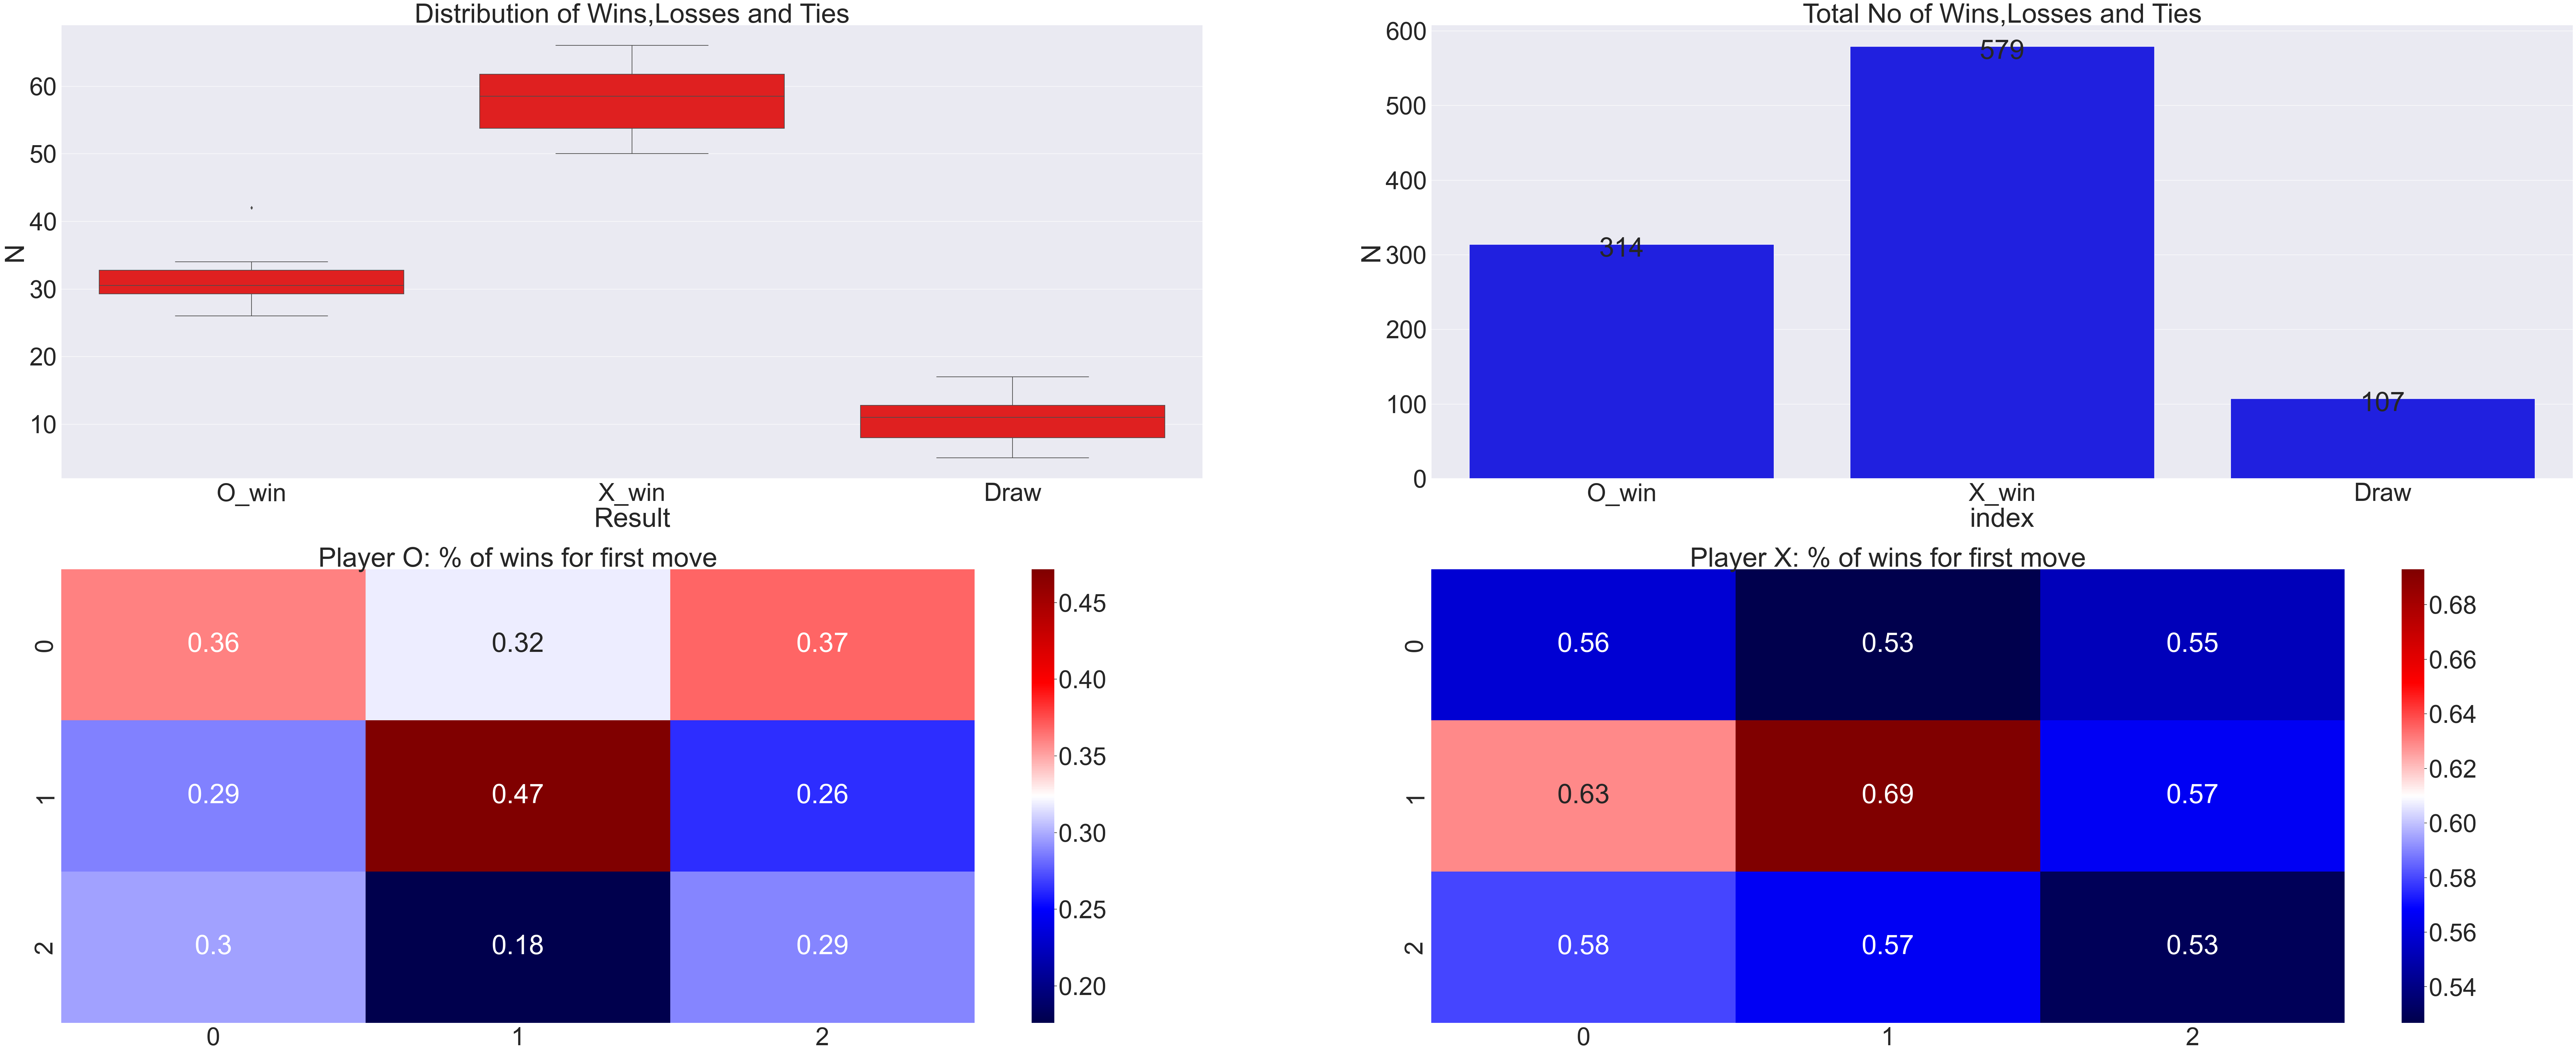

In [188]:
win_statistics= get_win_statistics(Q_X, Q_O, sets = 10, games_in_set = 100, X_strategy = 'eps_greedy',O_strategy='eps_greedy',eps_X=1.0,eps_O=1.0)# Setting eps = 1.0 ensures purely random policy
plot_results(win_statistics)

100%|██████████| 5000/5000 [00:05<00:00, 982.00it/s] 


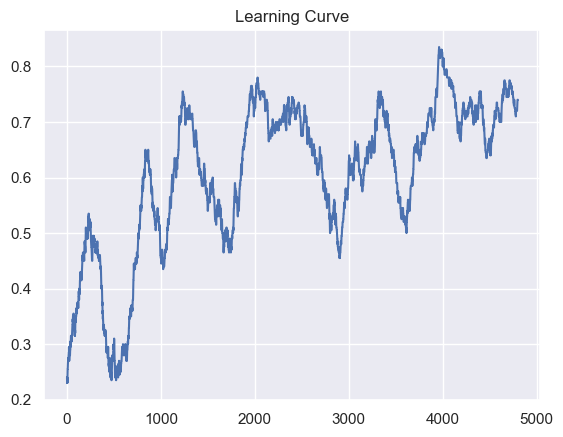

In [189]:
np.random.seed(1)
Q_X,_,rewards_X,rewards_O = train(n_games=5000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False,is_random=True)
Q_X_trained = Q_X

100%|██████████| 100/100 [00:00<00:00, 1101.48it/s]


<Figure size 640x480 with 0 Axes>

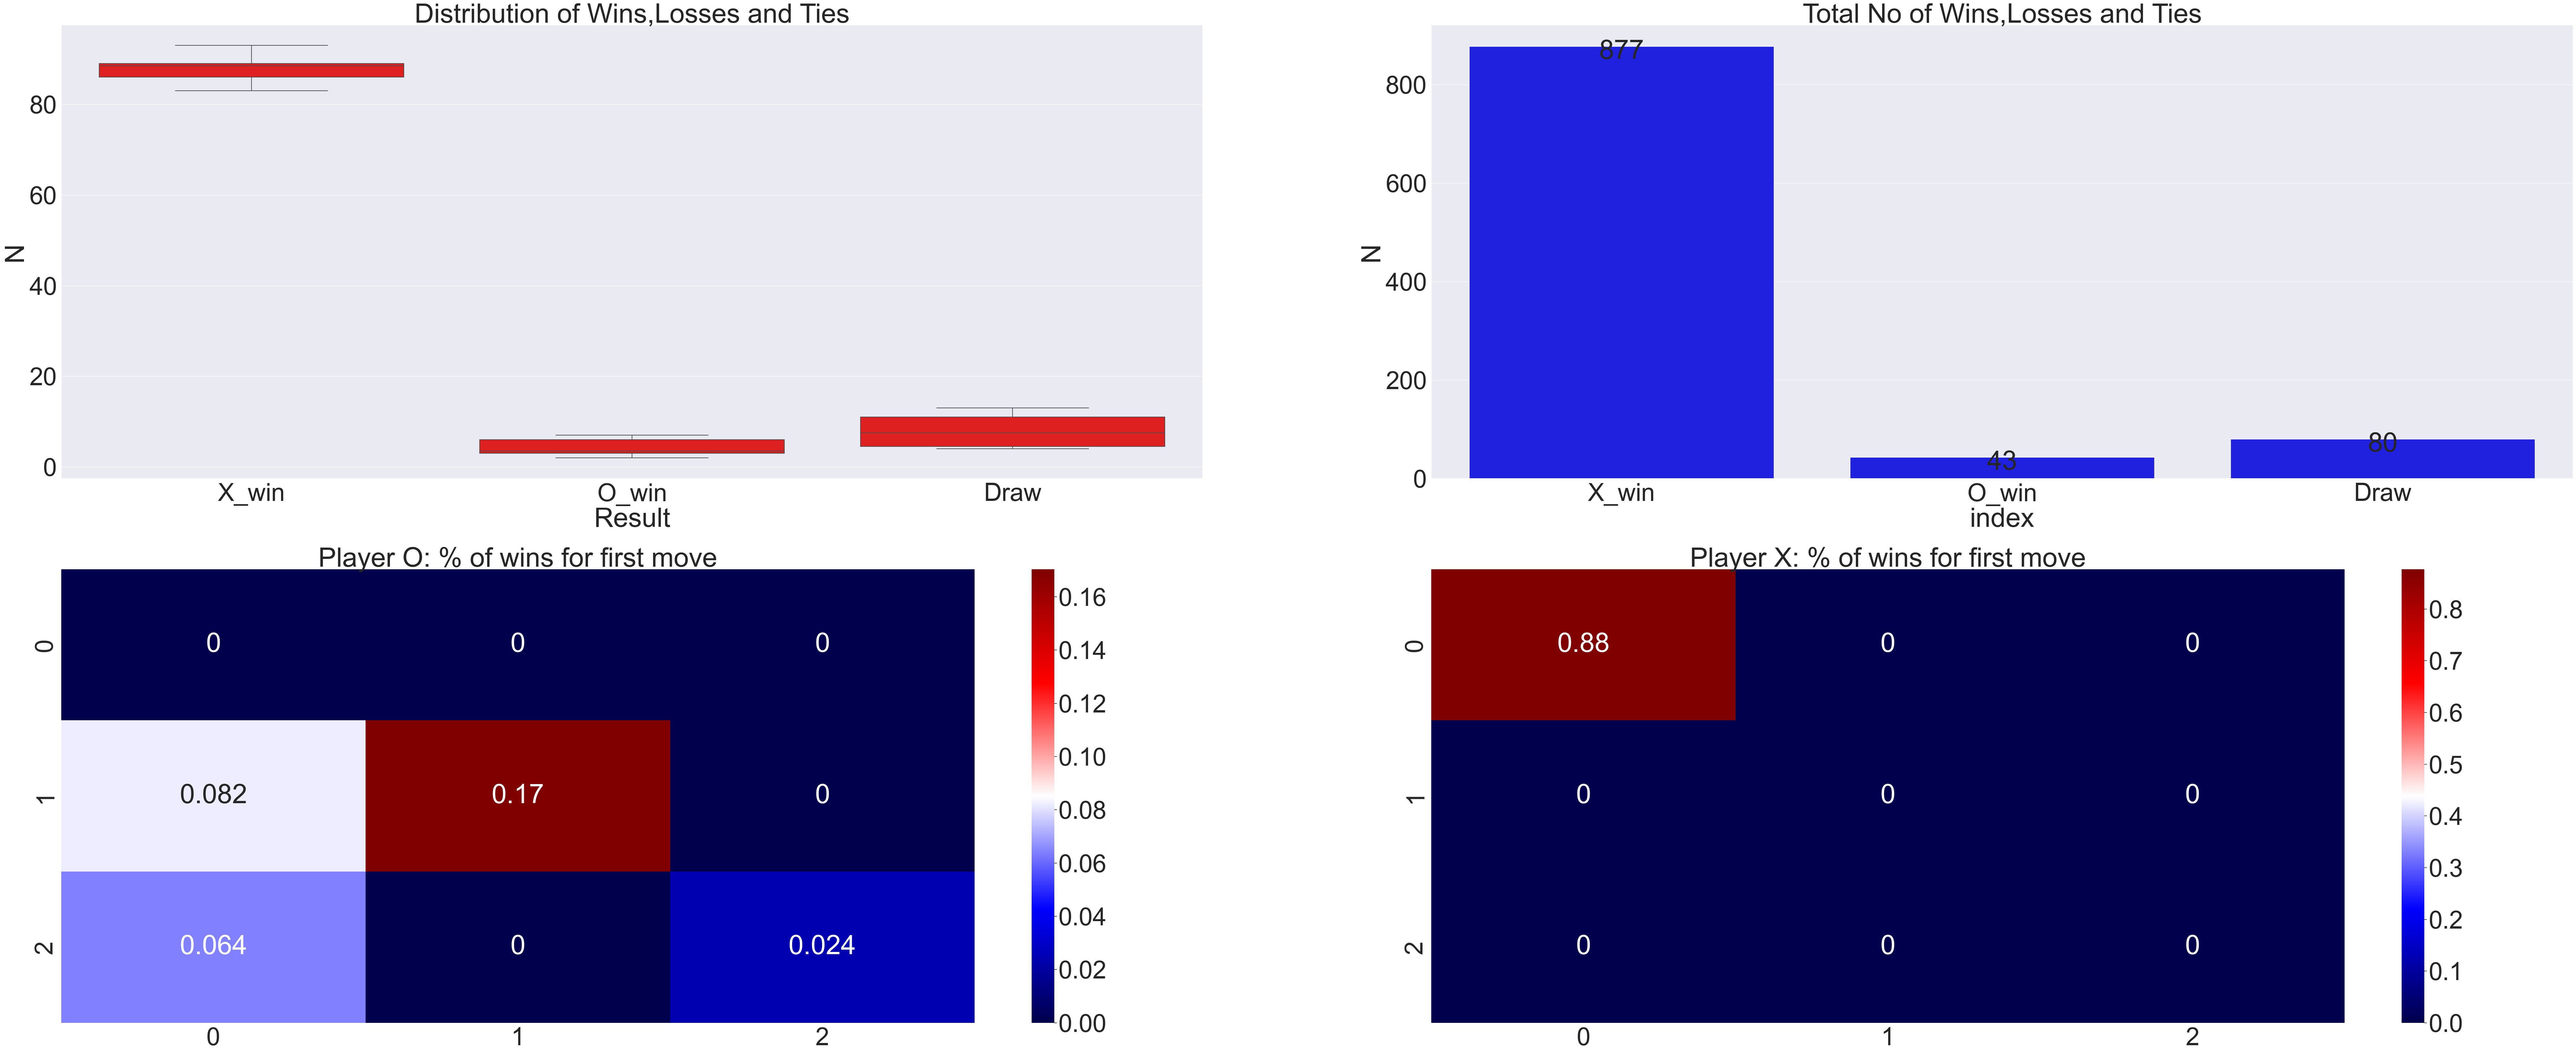

In [190]:
win_statistics = get_win_statistics(Q_X_trained, Q_O, sets = 10, games_in_set = 100, X_strategy = 'greedy', O_strategy='eps_greedy', eps_X=1.0, eps_O=1.0)
plot_results(win_statistics)

100%|██████████| 20000/20000 [00:19<00:00, 1010.80it/s]


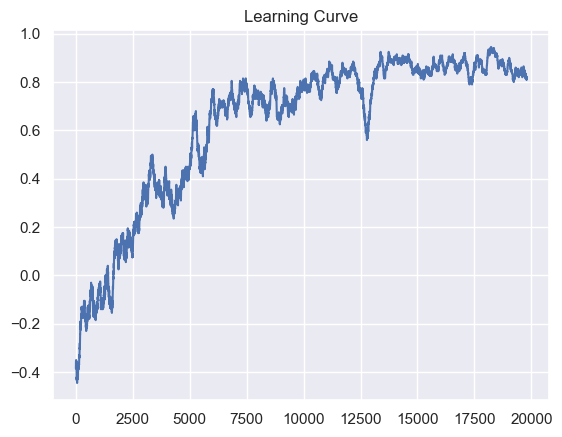

In [191]:
np.random.seed(1)
_, Q_O, rewards_X, rewards_O = train(n_games=20000,alpha = 0.5, gamma = 0.5, train_X=False, train_O=True, is_random=True)
Q_O_trained = Q_O

100%|██████████| 100/100 [00:00<00:00, 1099.17it/s]


<Figure size 640x480 with 0 Axes>

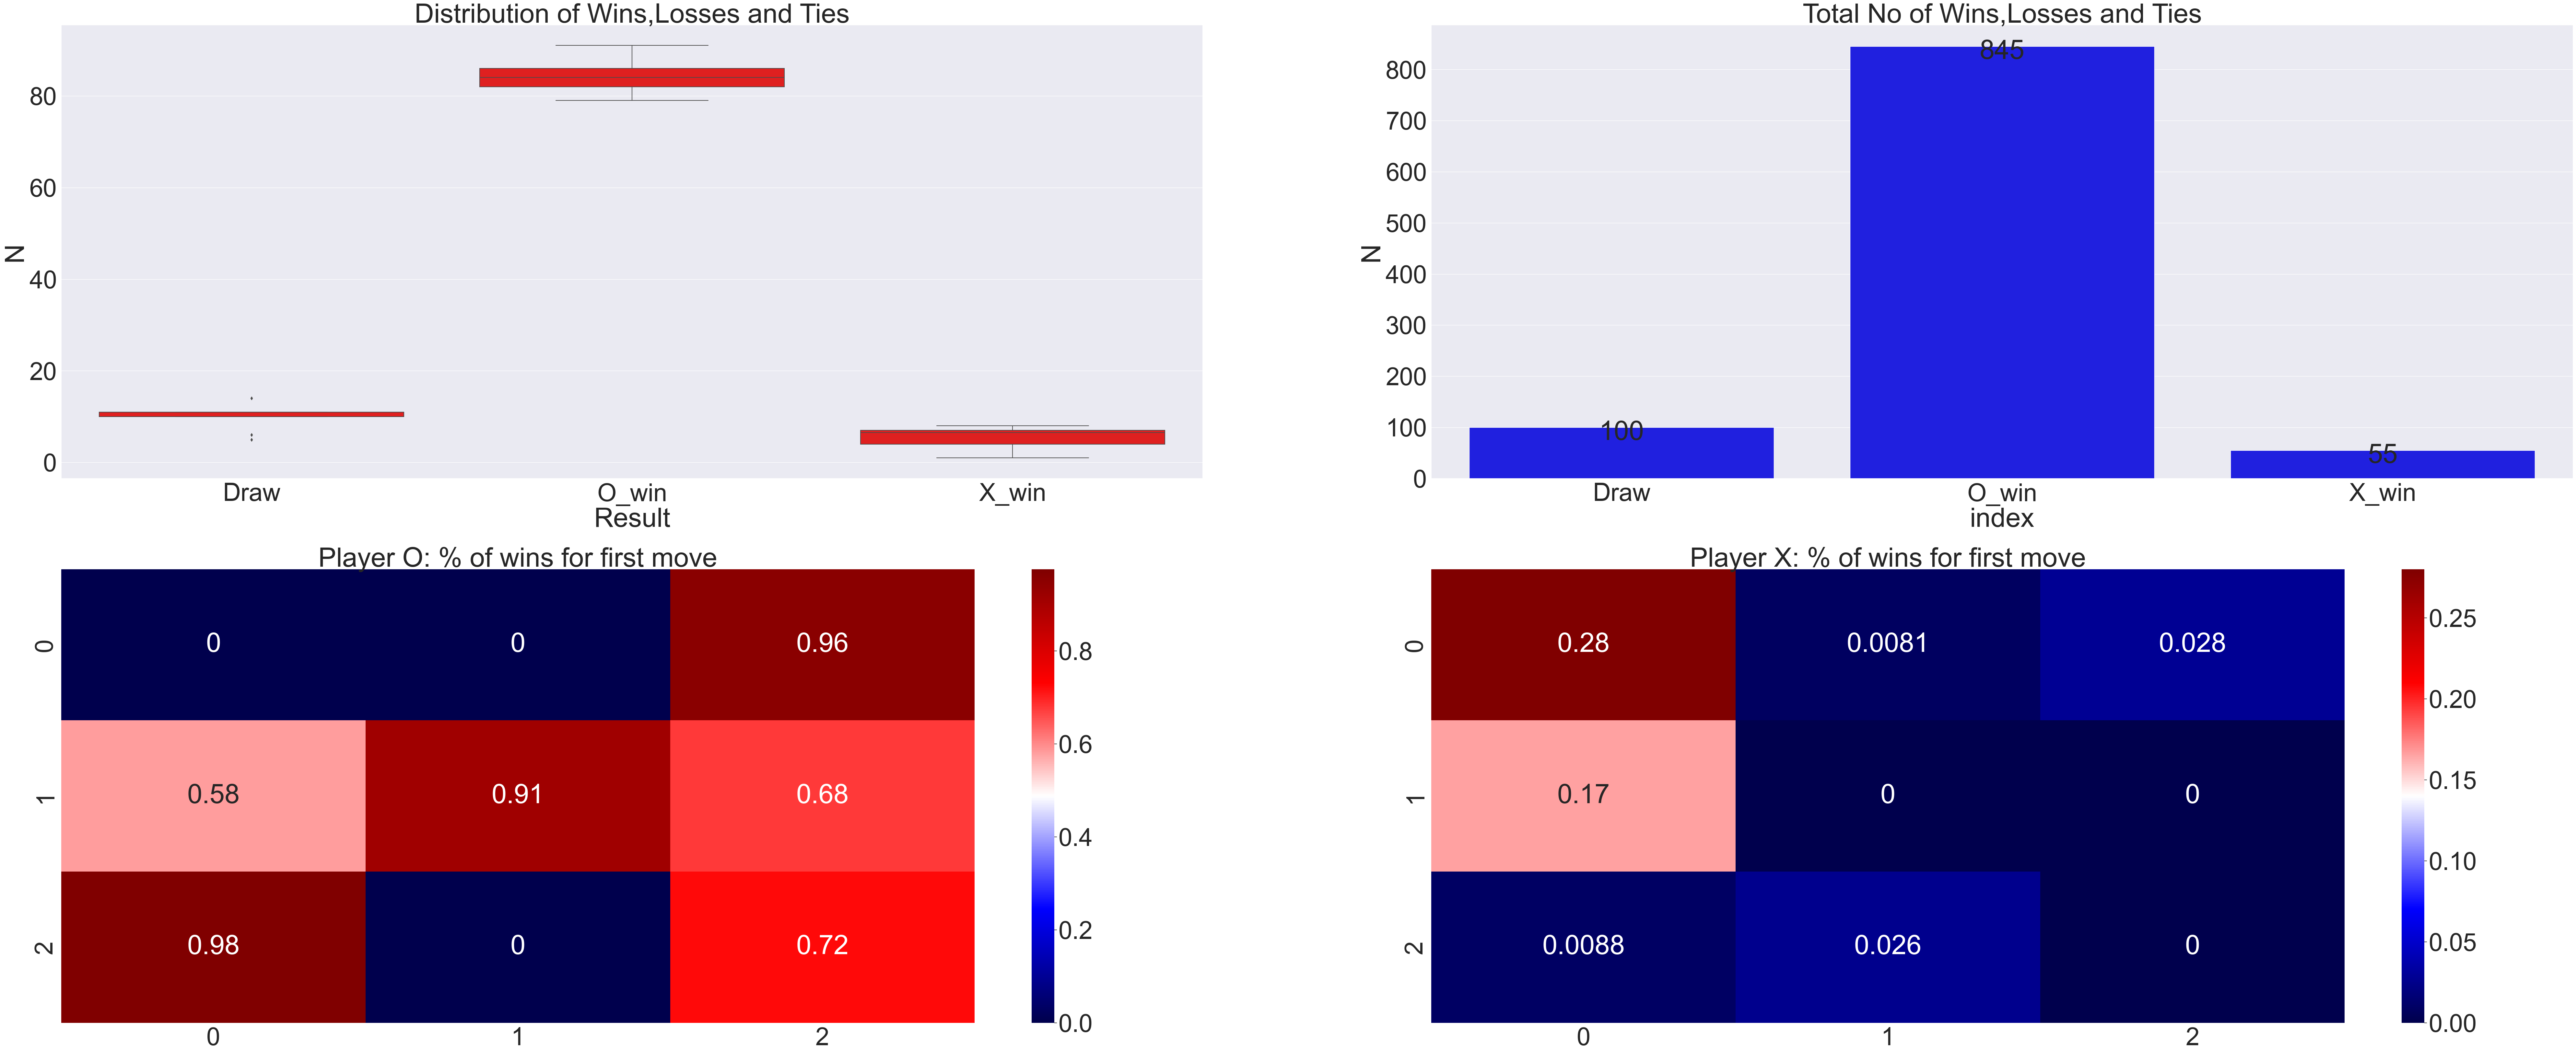

In [192]:
win_statistics = get_win_statistics(Q_X, Q_O_trained, sets = 10, games_in_set = 100, X_strategy = 'eps_greedy', O_strategy='greedy', eps_X=1.0, eps_O=1.0)
plot_results(win_statistics)

100%|██████████| 100/100 [00:00<00:00, 1349.99it/s]


<Figure size 640x480 with 0 Axes>

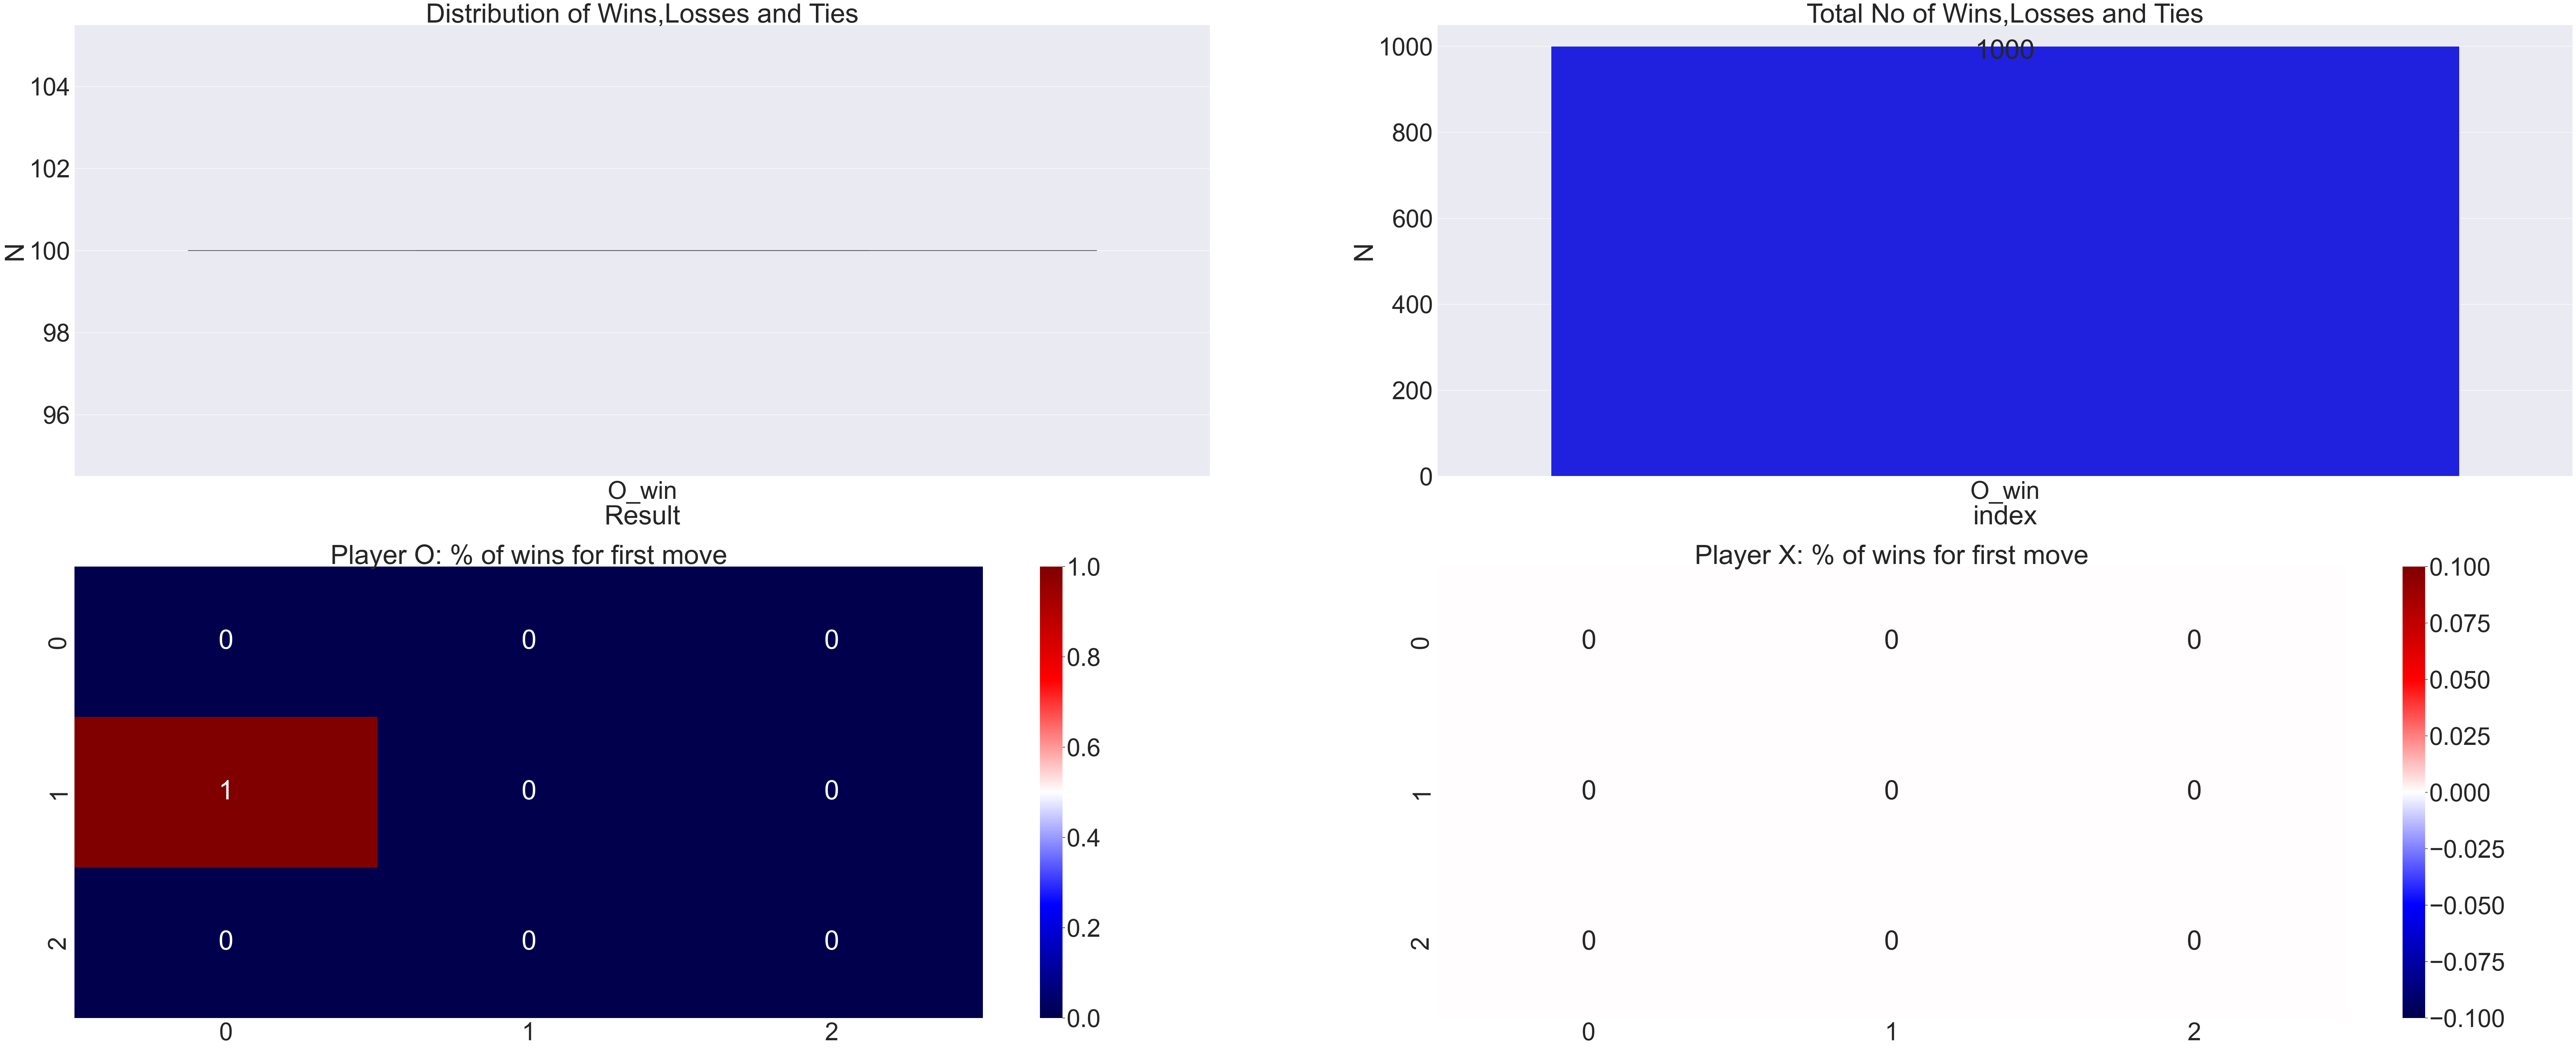

In [193]:
win_statistics = get_win_statistics(Q_X_trained, Q_O_trained, sets = 10, games_in_set = 100, X_strategy ='greedy', O_strategy='greedy', eps_X=1.0, eps_O=1.0)
plot_results(win_statistics)